Predicting Stock Market Prices Using HMM

# DATA GATHERING AND CLEANING 

In [1]:
from matplotlib import cm, pyplot as plt
import seaborn
from matplotlib.dates import YearLocator, MonthLocator, DayLocator
import pandas as pd
import numpy 
from datetime import datetime

def get_stock_data(file_name):
    """scrapes and cleans the data from the given file and creates a dataframe
    
    Args:
        file_name (string) : name of file
    
    Returns:
        df_stock (dataframe) : dataframe containing stock info scraped from file
    """
    df_stock = pd.DataFrame()
    file = open(file_name)
    txt = file.read()
    file.close()
    
    # split text into list, split by new line character
    txt = txt.split('\n')
    # get column titles
    columns = txt[0].split(',')

    for line in txt[1:]:
        temp_dict = dict()
        line = line.strip()
        line_list = line.split(',')

        # if row does not have sufficient column information, pass over
        if len(columns) != len(line_list):
            continue

        # add column's corresponding values to a temporary dictionary   
        for idx in range(len(columns)):
            column_name = columns[idx]
            
            # change all date column info to datetime object
            if column_name == 'Date':
                temp_dict[column_name] = datetime.strptime(line_list[idx], '%Y-%m-%d')
            else:
                temp_dict[column_name] = line_list[idx]

        # append dictionary to dataframe                                                  
        df_stock = df_stock.append(temp_dict, ignore_index=True)
    
    return df_stock

In [2]:
file_name = 'a.us.txt'
df_a_stock = get_stock_data(file_name)

test_df = df_a_stock.head(6)
test_df
#df_a_stock

,Close,Date,High,Low,Open,OpenInt,Volume
0,29.702,1999-11-18,33.754,27.002,30.713,0,66277506
1,27.257,1999-11-19,29.027,26.872,28.986,0,16142920
2,29.702,1999-11-22,29.702,27.044,27.886,0,6970266
3,27.002,1999-11-23,29.446,27.002,28.688,0,6332082
4,27.717,1999-11-24,28.309,27.002,27.083,0,5132147
5,27.807,1999-11-26,28.012,27.509,27.594,0,1832635


In [3]:
some_stock_files = ['a.us.txt', 'abc.us.txt', 'aktx.us.txt', 'blue.us.txt', 'bro.us.txt', 'by.us.txt',
                    'casi.us.txt', 'cbu.us.txt', 'cxdc.us.txt', 'dhr.us.txt', 'dxyn.us.txt', 'ebay.us.txt',
                    'eei.us.txt', 'eod.us.txt', 'fox.us.txt', 'ftrpr.us.txt', 'fwonk.us.txt']

In [4]:
def get_emission(stock_dataframe):
    """ Calculates the one day difference between stock closing value (today - yesterday)
        and determines emission symbol based on if stock price increased or decreased from previous day
    
    Args:
        stock_dataframe (dataframe) : dataframe containing stock info(close value, date, high, low, open, etc.)
    
    Returns:
        one_day_dif_df(dataframe) : dataframe containing the difference from the previous day's stock value
                                    as well as the related emission symbol (Increasing or Decreasing)
    """
    
    # Subset the initial DF to obtain only relevant columns
    one_day_dif_df = stock_dataframe.copy()
    one_day_dif_df = one_day_dif_df[['Date','Close']]
    
    # Convert CV to numeric for calculations
    one_day_dif_df['Close'] = pd.to_numeric(one_day_dif_df['Close'])
    one_day_dif_df['Yesterday Close'] = one_day_dif_df['Close'].shift()
    
    # Calculate the stock's closing price difference from the previous day
    one_day_dif_df['Close Value Difference'] = round((one_day_dif_df['Close'] - one_day_dif_df['Yesterday Close']),2)
    
    one_day_dif_df['Emission'] = 'NaN'
    row_indexes_inc = one_day_dif_df[one_day_dif_df['Close Value Difference']>=0].index
    row_indexes_dec = one_day_dif_df[one_day_dif_df['Close Value Difference']<0].index
    
    one_day_dif_df.loc[row_indexes_inc,'Emission']='Increasing'
    one_day_dif_df.loc[row_indexes_dec,'Emission']='Decreasing'
    #one_day_dif_df['Emission'] = ['Increasing' if x > 0 else 'Decreasing' for x in one_day_dif_df['Close Value Difference']]
    
    return one_day_dif_df

In [5]:
df_emission = get_emission(test_df)
df_emission

,Date,Close,Yesterday Close,Close Value Difference,Emission
0,1999-11-18,29.702,NaN,NaN,NaN
1,1999-11-19,27.257,29.702,-2.45,Decreasing
2,1999-11-22,29.702,27.257,2.45,Increasing
3,1999-11-23,27.002,29.702,-2.70,Decreasing
4,1999-11-24,27.717,27.002,0.71,Increasing
5,1999-11-26,27.807,27.717,0.09,Increasing


# EMP AND TMP MATRIX INITIALIZATION

In [6]:
def create_TPM(n):
    """creates transition probability matrix and initializes to equal random probabilities
    
    Args:
        n (int) : number of possible states
        
    Returns:
        tpm (array of arrays) : n by n transition probability matrix
                                    s1 s2 s3 s4 s5 s6
                                s1
                                s2
                                s3
                                s4
                                s5
                                s6
    """
    tpm = []
    
    for idx in range(n):
        rand_prob = round(1 / n, 2)
        row = []
        
        for idx in range(n):
            row.append(rand_prob)
            
        tpm.append(row)
    return tpm

In [7]:
tpm = create_TPM(6)

In [8]:
def create_EPM(n, m):
    """creates emissions probability matrix and initializes to equal random probabilities
    
    Args:
        n (int) : number of possible states
        m (int) : number of possible observation symbols
        
    Returns:
        epm (array of arrays) : n by m emission probability matrix
                                    I  D
                                s1
                                s2
                                s3
                                s4
                                s5
                                s6
    """
    
    epm = []
    
    for idx in range(n):
        rand_prob = round(1 / m, 2)
        row = []
        
        for idx in range(m):
            row.append(rand_prob)
            
        epm.append(row)
        
    return epm

In [9]:
epm = create_EPM(6, 2)
epm

[[0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]

# FORWARD BACKWARD ALGORITHM


Forward Backward Algorithm: the probability of an observation sequence occurring given the model. 

- Forward: probability that we are in a certain state, given we observed a certain sequence of historical observations
- Backward: probability that we will see a certain sequence of future observations, given we are in a certain state


In [10]:
def forward(tpm, epm, pi, observations):
    """probability that we are in a certain state, given we observed a certain sequence of historical observations
    
    Args:
        tpm (array of arrays) : transition probability matrix
        epm (array of arrays) : emission probability matrix
        pi (array) : initial distribution (probability of being in each state at the start)
        observations (array) : array of emission symbols observed
    
    Returns:
        frwd (int) : probability of being in a certain state
    """
    
    
    """
    Initialization visualization: 
        S1 S2 S3 S4 S5 S6
    T1  .2 .1 .1 .2 .1 .1  (PI)
        * EPM - probability of emitting whatever our first observation is 
    
    """ 
    
    # Create probability matrix forward[N,T] - initialize with 0s
    NUM_STATES = 6
    NUM_OBSERVATIONS = len(observations)
    OBSERVATIONS = observations
    alpha = []
    
    for T in range(NUM_OBSERVATIONS):
        row = []
        
        for N in range(NUM_STATES):
            if OBSERVATIONS[T] == "Increasing":
                row.append(pi[N] * epm[N][0])
            if OBSERVATIONS[T] == "Decreasing":
                row.append(pi[N] * epm[N][1])
            
        alpha.append(row)

    # for each time step from 2 to T
    for time in range(1, len(OBSERVATIONS)):
        curr_time_idx = time
        prev_time_idx = curr_time_idx - 1
        
        for state in range(NUM_STATES):
            prev_paths_sum = 0
            
            for s_prime in range(NUM_STATES):
                # prob of getting to each previous state through all possible paths 
                a = alpha[prev_time_idx][s_prime]
                
                # the transition probability from previous S to current S
                b = tpm[s_prime][state]
                
                # the emission probability of emitting observation at current S
                if OBSERVATIONS[time] == "Increasing":
                    c = epm[state][0]
                if OBSERVATIONS[time] == "Decreasing":
                    c = epm[state][1]
                    
                prev_paths_sum += a * b * c

            alpha[curr_time_idx][state] = prev_paths_sum

    return alpha

In [11]:
tpm = [[0.2, 0.1, 0.3, 0.1, 0.2, 0.1],
       [0.3, 0.1, 0.1, 0.2, 0.3, 0],
       [0.1, 0.1, 0.1, 0.3, 0.2, 0.2],
       [0.4, 0.1, 0.1, 0.1, 0.1, 0.2],
       [0.3, 0.2, 0.1, 0.1, 0.1, 0.2],
       [0.2, 0.2, 0.2, 0.1, 0.1, 0.2]]

In [12]:
emissions = ["Increasing", "Increasing", "Increasing", "Decreasing", "Decreasing"]
pi = [.2, .1, .1, .2, .1, .1]
frd = forward(tpm, epm, pi, emissions)
for observation in frd:
    print(observation)

[0.1, 0.05, 0.05, 0.1, 0.05, 0.05]
[0.052500000000000005, 0.025000000000000005, 0.0325, 0.027500000000000004, 0.03250000000000001, 0.030000000000000006]
[0.024, 0.013125000000000003, 0.01675, 0.014500000000000006, 0.016750000000000004, 0.014875000000000003]
[0.012106250000000004, 0.006581250000000001, 0.00814375, 0.007331250000000001, 0.008350000000000003, 0.007487500000000001]
[0.0060725000000000015, 0.003291875000000001, 0.004085000000000001, 0.003643437500000001, 0.004170625000000002, 0.003736562500000001]


## Forward Algorithm Test

In [13]:
import numpy as np

def forward_test(V, a, b, pi):
    """
    Args:
        V : emission matrix
        a : tpm
        b : epm
        pi : initial distribution
    
    Returns:
        alpha
        
    Citation:
        https://datascience.stackexchange.com/questions/74126/hidden-markov-model-forward-algorithm-implementation-in-python
    """
    alpha = np.zeros((len(V), len(a)))
    
    # alpha[0, :] = pi * b[:, V[0]]
    for state in range(len(alpha[0])):
        if V[0] == "Increasing":
                ob = epm[state][0]
        if V[0] == "Decreasing":
                ob = epm[state][1]
                
        alpha[0][state] = pi[state] * ob  
    
    # for each observation, 1 to T
    for t in range(1, len(V)):
        # for each state
        for j in range(len(a)):
            
            prev_state_sum = 0
            # for each state
            for s_prime in range(len(a)):
                
                if V[t] == "Increasing":
                    idx = 0
                if V[t] == "Decreasing":
                    idx = 1
                    
                prev_state_sum += alpha[t - 1][s_prime] * a[s_prime][j] * b[j][idx]
            
            alpha[t][j] = prev_state_sum

    return alpha

In [14]:
frd_test = forward_test(emissions, tpm, epm, pi)

for state in frd_test:
    print(state)

[0.1  0.05 0.05 0.1  0.05 0.05]
[0.0525 0.025  0.0325 0.0275 0.0325 0.03  ]
[0.024    0.013125 0.01675  0.0145   0.01675  0.014875]
[0.01210625 0.00658125 0.00814375 0.00733125 0.00835    0.0074875 ]
[0.0060725  0.00329188 0.004085   0.00364344 0.00417063 0.00373656]


In [15]:
for observation in range(len(frd)):
    for state in range(len(frd[observation])):
        # print(frd_test[observation][state], frd[observation][state])
        assert frd_test[observation][state] == frd[observation][state], "(observation, state) values do not match"

In [16]:
def backward(tpm, epm, pi, observations):
    """probability that we will see a certain sequence of future observations, given we are in a certain state
    
    Args:
        tpm (array of arrays) : transition probability matrix
        epm (array of arrays) : emission probability matrix
        pi () : initial distribution (probability of being in each state at the start)
        observations (array) : array of emission symbols observed
    
    Returns:
        backwd (int) : probability of being in a certain state
    """
    # Create probability matrix forward[N,T] - initialize with 0s
    NUM_STATES = 6
    NUM_OBSERVATIONS = len(observations)
    OBSERVATIONS = observations
    beta = []
    
    for T in range(NUM_OBSERVATIONS):
        row = []
        
        for N in range(NUM_STATES):
            row.append(1.0)
        
        beta.append(row)
    
    # recursion
    # for each time step from T-1 to 1 (end is exclusive)
    for time in range(len(OBSERVATIONS) - 2, -1, -1):
        
        for state in range(NUM_STATES):
            next_paths_sum = 0
            
            for s_prime in range(NUM_STATES):
                # prob of getting to each next state through all possible paths 
                a = beta[time+1][s_prime]
                
                # the transition probability from next S to current S
                b = tpm[state][s_prime]
                
                # the emission probability of emitting observation at next S
                if OBSERVATIONS[time] == "Increasing":
                    c = epm[s_prime][0]
                if OBSERVATIONS[time] == "Decreasing":
                    c = epm[s_prime][1]
                    
                next_paths_sum += a * b *c

            beta[time][state] = next_paths_sum

    return beta

In [17]:
back = backward(tpm, epm, pi, emissions)
for state in back:
    print(state)

[0.06250000000000001, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625]
[0.12500000000000003, 0.125, 0.125, 0.125, 0.125, 0.125]
[0.25000000000000006, 0.25, 0.25, 0.25, 0.25, 0.25]
[0.5000000000000001, 0.5, 0.5, 0.5, 0.5, 0.5]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


## Backward Algorithm Test

In [18]:
def backward_test(observations, trans, emis, numstates):
    backwardmatrix = numpy.zeros((len(observations), numstates))

    # initialization
    for s in range(numstates):
        backwardmatrix[len(observations) - 1][s] = 1.0

    # recursion
    for t in range(len(observations) - 2, -1, -1):
        
        if observations[t] == "Increasing":
            obs_index = 0
        if observations[t] == "Decreasing":
            obs_index = 1
        
        for s in range(numstates):
            
            for s2 in range(numstates):
                backwardmatrix[t][s] += trans[s][s2] * emis[s2][obs_index] * backwardmatrix[t+1][s2]

    return backwardmatrix

In [19]:
back_test = backward_test(emissions, tpm, epm, 6)

for state in back_test:
    print(state)

[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]
[0.125 0.125 0.125 0.125 0.125 0.125]
[0.25 0.25 0.25 0.25 0.25 0.25]
[0.5 0.5 0.5 0.5 0.5 0.5]
[1. 1. 1. 1. 1. 1.]


In [20]:
for observation in range(len(emissions)):
    for state in range(len(back[observation])):
        # print(back_test[observation][state], back[observation][state])
        assert back_test[observation][state] == back[observation][state], "(observation, state) values do not match"

In [21]:
def frwd_backwd(tpm, epm, init, observations):
    """the probability of an observation sequence occurring given the model
    
    Args:
        tpm (array of arrays) : transition probability matrix
        epm (array of arrays) : emission probability matrix
        init () : initial distribution (probability of being in each state at the start)
        observations (array) : array of emission symbols observed
    
    Returns:
        frwd_backwd (int) : probability of an observation sequence occurring
    """
    frwd = forward(tpm, epm, pi, observations)
    bkwd = backward(tpm, epm, pi, observations)

    # matrix multiplication
    result = [[sum(frwd*bkwd for frwd,bkwd in zip(X_row,Y_col)) for Y_col in zip(*bkwd)] for X_row in frwd]

    return result

In [22]:
frwd_backwd(tpm, epm, pi, emissions)

[[0.12500000000000003, 0.125, 0.125, 0.125, 0.125, 0.125],
 [0.060781250000000016,
  0.06078125000000001,
  0.06078125000000001,
  0.06078125000000001,
  0.06078125000000001,
  0.06078125000000001],
 [0.03132812500000001,
  0.03132812500000001,
  0.03132812500000001,
  0.03132812500000001,
  0.03132812500000001,
  0.03132812500000001],
 [0.015630859375000007,
  0.015630859375000004,
  0.015630859375000004,
  0.015630859375000004,
  0.015630859375000004,
  0.015630859375000004],
 [0.007804609375000004,
  0.007804609375000002,
  0.007804609375000002,
  0.007804609375000002,
  0.007804609375000002,
  0.007804609375000002]]

# BAUM WELCH ALGORITHM

Given a sequence of observed values, determine the parameters of the HMM that generated that data.

In [23]:
frwd = forward(tpm, epm, pi, emissions)
bkwd = backward(tpm, epm, pi, emissions)

In [24]:
def check_convergence(old_matrix, new_matrix):
    """returns true if matricies have converged (aka are the same), false otherwise
    
    Args:
        old_matrix (array of arrays) : old matrix
        new_matrix (array of arrays) : new matrix
        
    Returns:
        converge (boolean) : represents whether the given matricies have converged or not
        
    """
    converge = True
    for col in range(len(old_matrix)):
        for row in range(len(old_matrix[col])):
            if old_matrix[col][row] != new_matrix[col][row]:
                converge = False
    
    return converge

In [25]:
# test check_covergence()

old_matrix = [[1, 2], [3, 4], [5, 6]]
new_matrix = [[1, 2], [3, 4], [5, 6]]

assert check_convergence(old_matrix, new_matrix) == True, "method claims matricies have not converged"

new2_matrix = [[1, 2], [2, 2], [5, 6]]

assert check_convergence(old_matrix, new2_matrix) == False, "method claims matricies have converged"

In [26]:
def baum_welch(tpm, epm, pi, emissions):
    """probability of initial parameters that generated emissions data
    
    Args:
        tpm (array of arrays) : transition probability matrix
        epm (array of arrays) : emission probability matrix
        pi (array) : initial distribution (probability of being in each state at the start)
        observations (array) : array of emission symbols observed
    
    Returns:
    
    """
    # transition probabilities
    A = np.zeros((6, 6))
    # observation probabilities
    B = np.ones((len(emissions) + 1, 2))
    
    # xi dictionary
    xi = dict()
    # gamma dictionary
    gamma = dict()
    
    # iterate until convergence
    # while (check_convergence(tpm, A) == False and check_convergence(epm, B) == False):
    
    # HOW CHECK CONVERGENCE? JUST RUN 10 TIMES
    for i in range(10):
        
        # E STEP

        for time in range(len(emissions)):
    
             # get normalization constant for time P(O|HMM)
            normalization_const = 0
            for state in range(6):
                normalization_const += frwd[time][state] * bkwd[time][state]

            for state_i in range(6):
                # update gamma values for (time, state_i) in gamma dictionary
                gamma[(time, state_i)] = (frwd[time][state_i] * bkwd[time][state_i]) / normalization_const

        for time in range(len(emissions) - 1):

                # get emissions index
                if emissions[time] == "Increasing":
                    idx = 0
                if emissions[time] == "Decreasing":
                    idx = 1

                for state_i in range(6):

                    for state_j in range(6):

                        # update xi values for (time, state_i, state_j) in xi dictionary
                        temp_xi = frwd[time][state_j] * tpm[state_i][state_j] * epm[state_j][idx] * bkwd[time + 1][state_j]
                        xi[(time, state_i, state_j)] = temp_xi / normalization_const
        
        # M STEP
        
        # update alpha
        for state_i in range(6):
            for state_j in range(6):

                nominator_sum = 0
                denom_sum = 0

                for time in range(1, len(emissions) - 1):
                    nominator_sum += xi[(time, state_i, state_j)]

                    temp_sum = 0
                    for state_prime in range(6):
                        temp_sum += xi[(time, state_i, state_prime)]

                    denom_sum += temp_sum

                A[state_i][state_j] = nominator_sum / denom_sum

        # update beta

        increasing_idx = 0     # tracked observation variable
        for state in range(6):

            numerator = 0
            denom = 0

            for time in range(len(emissions)):

                if emissions[time] == "Increasing":
                    numerator += gamma[(time, state)]

                denom += gamma[(time, state)]

                B[state][increasing_idx] = numerator / denom
                B[state][1] = 1 - (numerator / denom)
    for item in gamma:
        print(item, gamma[item])
    return A, B

In [27]:
A, B = baum_welch(tpm, epm, pi, emissions)

(0, 0) 0.25000000000000006
(0, 1) 0.125
(0, 2) 0.125
(0, 3) 0.25
(0, 4) 0.125
(0, 5) 0.125
(1, 0) 0.26250000000000007
(1, 1) 0.125
(1, 2) 0.16249999999999998
(1, 3) 0.13749999999999998
(1, 4) 0.1625
(1, 5) 0.15
(2, 0) 0.24000000000000002
(2, 1) 0.13125
(2, 2) 0.16749999999999998
(2, 3) 0.14500000000000002
(2, 4) 0.1675
(2, 5) 0.14875
(3, 0) 0.24212500000000006
(3, 1) 0.131625
(3, 2) 0.16287499999999994
(3, 3) 0.14662499999999998
(3, 4) 0.167
(3, 5) 0.14974999999999997
(4, 0) 0.24289999999999998
(4, 1) 0.131675
(4, 2) 0.1634
(4, 3) 0.1457375
(4, 4) 0.166825
(4, 5) 0.1494625


## Baum Welch Test

In [28]:
def baum_welch_test(V, a, b, pi, n_iter=100):
    M = 6
    T = len(V)
 
    for n in range(n_iter):
        alpha = forward(tpm, epm, pi, emissions)
        beta = backward(tpm, epm, pi, emissions)
 
        xi = np.zeros((M, M, T - 1))
        for t in range(T - 1):
            
            denominator = 0
            
            for state in range(M):
                # get emissions index
                if V[t + 1] == "Increasing":
                    idx = 0
                if V[t + 1] == "Decreasing":
                    idx = 1
                    
                const_a = np.dot(alpha[t][state], a)
                const_b = b[state][idx]
                const_c = beta[t + 1][state]
                
                # cant np.dot() three items, so doing it in 2 steps
                temp = np.dot(const_a, const_b)
                denominator += np.dot(temp, const_c)
                
                
            print(denominator)
            for i in range(M):
                
                numerator = 0
                for state in range(M):
                    # get emissions index
                    if V[t + 1] == "Increasing":
                        idx = 0
                    if V[t + 1] == "Decreasing":
                        idx = 1
                        
                    numerator += alpha[t][i] * a[i][state] * b[state][idx] * beta[t + 1][state]
                    
                    xi[i, state, t] = numerator / denominator[i][state] # DENOM RETURNS MATRIX, WHAT VALUE TO CHOOSE???
        print(xi)
        gamma = np.sum(xi, axis=1)
        a = np.sum(xi, 2) / np.sum(gamma, axis=1).reshape((-1, 1))
        
        #print(gamma)
 
        # Add additional T'th element in gamma
        gamma = np.hstack((gamma, np.sum(xi[:, :, T - 2], axis=0).reshape((-1, 1))))

        # number of observations
        K = 2
        denominator = np.sum(gamma, axis=1)
        for emission in range(K):
            
            for time in range(T - 1):
                # get emissions index
                if V[time] == "Increasing":
                    idx = 0
                if V[time] == "Decreasing":
                    idx = 1
                    
                b_sum = 0
                for state_i in range(M):
                    if emission == idx:
                        b_sum += gamma[state_i][time]
                
                b[state_i][emission] = b_sum
 
        b = np.divide(b, denominator.reshape((-1, 1)))
 
    return {"a":a, "b":b}

In [29]:
baum_welch_test(emissions, tpm, epm, pi, n_iter=10)

[[0.005  0.0025 0.0075 0.0025 0.005  0.0025]
 [0.0075 0.0025 0.0025 0.005  0.0075 0.    ]
 [0.0025 0.0025 0.0025 0.0075 0.005  0.005 ]
 [0.01   0.0025 0.0025 0.0025 0.0025 0.005 ]
 [0.0075 0.005  0.0025 0.0025 0.0025 0.005 ]
 [0.005  0.005  0.005  0.0025 0.0025 0.005 ]]
[[0.005  0.0025 0.0075 0.0025 0.005  0.0025]
 [0.0075 0.0025 0.0025 0.005  0.0075 0.    ]
 [0.0025 0.0025 0.0025 0.0075 0.005  0.005 ]
 [0.01   0.0025 0.0025 0.0025 0.0025 0.005 ]
 [0.0075 0.005  0.0025 0.0025 0.0025 0.005 ]
 [0.005  0.005  0.005  0.0025 0.0025 0.005 ]]
[[0.005  0.0025 0.0075 0.0025 0.005  0.0025]
 [0.0075 0.0025 0.0025 0.005  0.0075 0.    ]
 [0.0025 0.0025 0.0025 0.0075 0.005  0.005 ]
 [0.01   0.0025 0.0025 0.0025 0.0025 0.005 ]
 [0.0075 0.005  0.0025 0.0025 0.0025 0.005 ]
 [0.005  0.005  0.005  0.0025 0.0025 0.005 ]]
[[0.005  0.0025 0.0075 0.0025 0.005  0.0025]
 [0.0075 0.0025 0.0025 0.005  0.0075 0.    ]
 [0.0025 0.0025 0.0025 0.0075 0.005  0.005 ]
 [0.01   0.0025 0.0025 0.0025 0.0025 0.005 ]
 [0.007

<ipython-input-28-b8f2ca764a78>:43: RuntimeWarning: divide by zero encountered in double_scalars
  xi[i, state, t] = numerator / denominator[i][state] # DENOM RETURNS MATRIX, WHAT VALUE TO CHOOSE???
<ipython-input-28-b8f2ca764a78>:46: RuntimeWarning: invalid value encountered in true_divide
  a = np.sum(xi, 2) / np.sum(gamma, axis=1).reshape((-1, 1))
<ipython-input-28-b8f2ca764a78>:72: RuntimeWarning: invalid value encountered in true_divide
  b = np.divide(b, denominator.reshape((-1, 1)))
<ipython-input-10-4eace1f230cc>:61: RuntimeWarning: invalid value encountered in double_scalars
  prev_paths_sum += a * b * c
<ipython-input-16-96b97f5d25e5>:47: RuntimeWarning: invalid value encountered in double_scalars
  next_paths_sum += a * b *c
<ipython-input-28-b8f2ca764a78>:41: RuntimeWarning: invalid value encountered in double_scalars
  numerator += alpha[t][i] * a[i][state] * b[state][idx] * beta[t + 1][state]


{'a': array([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan]]),
 'b': array([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]])}

# VITERBI ALGORITHM


Given a sequence of observed values, provide us with the sequence of states the HMM most likely has been in to generate such values sequence.

In [39]:
def viterbi(tpm, epm, pi, observations):
    """Given a sequence of observed values, provide us with the sequence of states 
        the HMM most likely has been in to generate such values sequence
    
    Args:
        tpm (array of arrays) : transition probability matrix
        epm (array of arrays) : emission probability matrix
        pi (array) : initial distribution (probability of being in each state at the start)
        observations (array) : array of emission symbols observed
    
    Returns: array of the most probable state-sequence based on the observations and HMM model
    """
    
    num_states = 6
    states_names = ['very_low','low','moderate_low','moderate_high','high','very_high' ]
    
    # create path probability matrix num observations by num states
    # initialize to 0
    path_probability_matrix = numpy.zeros((len(observations), num_states ))

    #create a path backpointer matrix backpointer[N, L + 2] to save indexes of states
    # initialize to 0
    path_backpointer_maxtrix = numpy.zeros((len(observations)+1, num_states ))
    
    max_states = np.zeros(len(observations))
    final_path=[]
    final_path = ['starting' for i in range(len(observations))]

    
    #grab first observation to determine which EPM index to use
    if observations[0] == "Increasing":
        obs_index = 0
    else:
        obs_index = 1
        
    # update first row of path_probability_matrix matrix
    # first row = probability of starting in each state * prob of seeing observation in that state
    for s in range(num_states):
        path_probability_matrix[0][s] = pi[s] * epm[s][obs_index] 
        
    
    for t in range(1, len(observations)):
        for s in range(num_states):
            
            backpointer_probabilities = []
            probabilities = []
            
            for s_prime in range(num_states):
                
                # prob of getting to each previous state through all possible paths
                a = path_probability_matrix[t-1][s_prime]
                
                # the transition probability from previous S to current S
                b = tpm[s_prime][s]
                
                backpointer_prob = a * b
                backpointer_probabilities.append(backpointer_prob)
                
                # the emission probability of emitting observation at current S
                if observations[t-1] == "Increasing":
                    c = epm[s][0]
                if observations[t-1] == "Decreasing":
                    c = epm[s][1]
                    
                path_probability = a * b * c
                probabilities.append(path_probability)
        
            # update path_probability_matrix[t,s] to MAX probability of most prob state for previous observation
            path_probability_matrix[t][s] = max(probabilities)

            # update back_pointer[t, s] to be argMax calculated of previous obs for given observation
            path_backpointer_maxtrix[t][s] = numpy.argmax(backpointer_probabilities)
            
    #grab end state probability and index 
    end_state_probability = max(path_probability_matrix[-1:])
    end_state_index = numpy.argmax(path_probability_matrix[-1:])

    #go backwards through backpointer
    final_path[len(observations)-1] = end_state_index
    
    for i in range(len(observations)-2, -1, -1):
        final_path_state = path_backpointer_maxtrix[i+1][int(end_state_index)]
        final_path[i] = final_path_state
        end_state_index = int(final_path_state)

    print(final_path)
    return(final_path)
        

In [40]:
# test using the emissions 

#emissions_test =  ["Increasing", "Increasing", "Increasing", "Decreasing", "Decreasing"]
#emissions_test = ['NaN', 'Decreasing', 'Increasing', 'Decreasing', 'Increasing', 'Increasing']
emissions_test = df_emission['Emission']
print(emissions_test)
viterbi(tpm, epm, pi, emissions)

0           NaN
1    Decreasing
2    Increasing
3    Decreasing
4    Increasing
5    Increasing
Name: Emission, dtype: object
[3.0, 0.0, 2.0, 3.0, 5]


<ipython-input-39-ca6c5247599a>:64: RuntimeWarning: invalid value encountered in double_scalars
  path_probability = a * b * c


[3.0, 0.0, 2.0, 3.0, 5]

In [32]:
df_emission

,Date,Close,Yesterday Close,Close Value Difference,Emission
0,1999-11-18,29.702,NaN,NaN,NaN
1,1999-11-19,27.257,29.702,-2.45,Decreasing
2,1999-11-22,29.702,27.257,2.45,Increasing
3,1999-11-23,27.002,29.702,-2.70,Decreasing
4,1999-11-24,27.717,27.002,0.71,Increasing
5,1999-11-26,27.807,27.717,0.09,Increasing


### Graphing Viterbi Output

In [33]:
# add the outcome of hidden states to the stock dataframe

states_path = viterbi(tpm, epm, pi, emissions)

def add_hidden_states_to_df(original_stock_df, states_path):
    """ Add the calcuated hidden state sequence to the original stock dataframe
    
    Args:
        original_stock_df (dataframe): original dataframe with stock information used in HMM
        states_path (array): calculated state sequence using HMM
    
    Returns: updated stock DataFrame including the probable state-sequence based on the observations and HMM model
    """

    states_path_df = pd.DataFrame(states_path,columns=['States_Path'])
    states_path_df.loc[-1] = 'starting state' # add starting state because it is NaN row
    states_path_df.index = states_path_df.index + 1  # shifting index
    states_path_df = states_path_df.sort_index()
    states_path_df.T

    updated_stock_df = original_stock_df.copy()

    updated_stock_df['Hidden_State'] = states_path_df['States_Path']
    
    return(updated_stock_df)


before loop finalpath is ['starting', 'starting', 'starting', 'starting', 5]
i is... 3
finalpath in for loop is ['starting', 'starting', 'starting', 3.0, 5]
i is... 2
finalpath in for loop is ['starting', 'starting', 2.0, 3.0, 5]
i is... 1
finalpath in for loop is ['starting', 0.0, 2.0, 3.0, 5]
i is... 0
finalpath in for loop is [3.0, 0.0, 2.0, 3.0, 5]
[3.0, 0.0, 2.0, 3.0, 5]


<ipython-input-30-49047bceef66>:64: RuntimeWarning: invalid value encountered in double_scalars
  path_probability = a * b * c


In [34]:
updated_stock_df = add_hidden_states_to_df(df_emission, states_path)
updated_stock_df

,Date,Close,Yesterday Close,Close Value Difference,Emission,Hidden_State
0,1999-11-18,29.702,NaN,NaN,NaN,starting state
1,1999-11-19,27.257,29.702,-2.45,Decreasing,3
2,1999-11-22,29.702,27.257,2.45,Increasing,0
3,1999-11-23,27.002,29.702,-2.70,Decreasing,2
4,1999-11-24,27.717,27.002,0.71,Increasing,3
5,1999-11-26,27.807,27.717,0.09,Increasing,5


In [35]:
def graph_hidden_states(updated_stock_df):
    """ Graph the hidden states by date and close price
    
    Args:
        updated_stock_df (dataframe): dataframe with stock information used in HMM and determined hidden states
    
    Returns: Nothing, but graphs the input DF.
    """

    dates = updated_stock_df["Date"]
    close_v = updated_stock_df["Close"]
    states = updated_stock_df["Hidden_State"]

    fig, axs = plt.subplots(len(updated_stock_df.Hidden_State.unique()), sharex=True, sharey=True)
    colours = cm.rainbow(numpy.linspace(0, 1, (len(updated_stock_df.Hidden_State.unique()))))
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        # Use fancy indexing to plot data in each state.
        mask = states == i
        ax.plot_date(dates[mask], close_v[mask], ".-", c=colour)
        ax.set_title("{0}th hidden state".format(i))
        ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)

    # set axis
    plt.xlim(dates[0], dates[len(dates)-1])

    # set y-axis
    plt.ylim(0, numpy.amax(close_v) + 10)

    # plt.xlim(1, 10)
    fig.set_size_inches(15, 15)
    seaborn.set()
    plt.show(), states_path

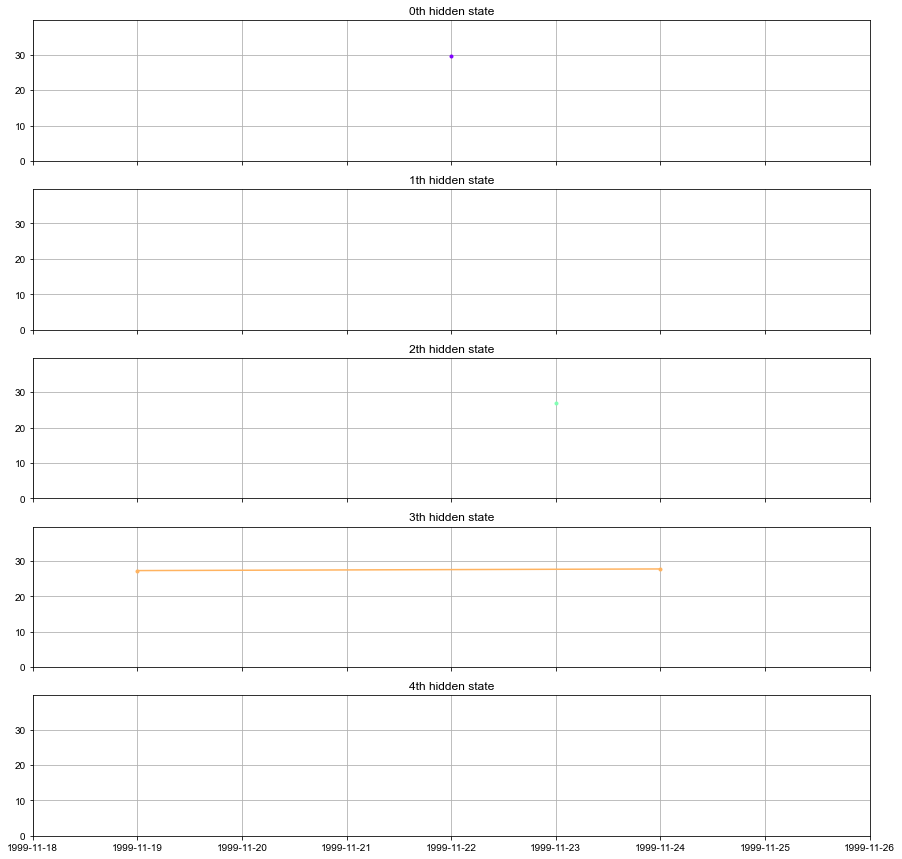

In [36]:
graph_hidden_states(updated_stock_df)